In [1]:
import os
import sys

# Add Election Package to Path
ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2]) 
sys.path.append(ROOT_DIR)

from functools import reduce
from sandbox_ggemelos.transaction_analysis.utils import fetch_transactions, fetch_statement_of_org
from sandbox_ggemelos.transaction_analysis.graphs import Graph
import numpy as np
import datetime
from collections import defaultdict as ddict
import itertools
import pandas as pd
from typing import Iterable, Dict

import networkx as nx
from networkx.algorithms import approximation as nxalg
from networkx.algorithms.components import connected as nxconn
import networkx.algorithms.centrality as nxcent

import matplotlib.pyplot as plt
%matplotlib inline

/Users/ggemelos/anaconda3/envs/elections2018/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
START_DATE = datetime.date(2016, 11, 15)
END_DATE = datetime.date(2017, 11, 15)

stmnt_of_org = fetch_statement_of_org()
trans = fetch_transactions(statement_of_org=stmnt_of_org,
                           start_date=START_DATE,
                           end_date=END_DATE)
trans = trans[trans['amount'] > 0]

committee_name_lookup = {cid:cname for cid, cname in stmnt_of_org[['committee_id', 'committee_name']].drop_duplicates().values}

In [3]:
# Filter out bad payees 
invalid_payees = set(['Miscellaneous Cash Expenditures $100 and under', 
                      'Miscellaneous Cash Contributions $100 and under'])
trans['is_valid'] = trans['contributor_payee'].apply(lambda x: x != 'None' and x not in invalid_payees and x.count('$') == 0)
trans = trans[trans['is_valid']]

In [4]:
# Sum all transactions between parties

MIN_TOTAL_DONATIONS = 1000

def map_to_dict(data):
    contributors = data.contributor_payee.values
    amounts = data.amount.values
    return {cont:amt for cont, amt in zip(contributors, amounts)}

agg_contributions = trans.groupby(['committee_id', 'contributor_payee']).sum().reset_index()\
                         .groupby(['committee_id']).apply(map_to_dict).reset_index()
agg_contributions.columns = ['committee_id', 'donors']

# Remove committes with less than given min donations
agg_contributions['is_valid'] = agg_contributions['donors'].apply(lambda x: sum(x.values()) >= MIN_TOTAL_DONATIONS)
agg_contributions = agg_contributions[agg_contributions['is_valid']]
del agg_contributions['is_valid']

In [5]:
# Calculate correlations
projections = dict()
for comm1, comm2 in itertools.combinations(agg_contributions.values, 2):
    cid1, cont1 = comm1
    cid2, cont2 = comm2

    pids = list(set(cont1.keys()) | set(cont2.keys()))

    sig1 = np.array([cont1[pid] if pid in cont1 else 0 for pid in pids])
    sig2 = np.array([cont2[pid] if pid in cont2 else 0 for pid in pids])

    sig1 = sig1 / np.linalg.norm(sig1)
    sig2 = sig2 / np.linalg.norm(sig2)
    
    projections[(cid1, cid2) if cid1 < cid2 else (cid2, cid1)] = (np.dot(sig1, sig2), len(set(cont1.keys()) & set(cont2.keys())))

In [6]:
# Functions for looking at group funding
def group_summary(agg_contributions: pd.DataFrame, committees: Iterable[str], mode: str='union', min_prct: float=0.01) -> Dict[str, float]:
    
    data = []
    for cid in committees:
        temp = agg_contributions[agg_contributions['committee_id'] == cid]['donors'].values
        if temp.size > 0:
            data.append((cid, temp[0]))
    
    if mode == 'intersection':
        pids = list(reduce(lambda x, y: x & y, (set(donors.keys()) for cid, donors in data)))
    elif mode == 'union':
        pids = list(reduce(lambda x, y: x | y, (set(donors.keys()) for cid, donors in data)))
        
    sigantures = []
    for cid, donors in data:
        siganture = np.array([donors[pid] if pid in donors else 0 for pid in pids])
        siganture = siganture / np.linalg.norm(siganture)
        sigantures.append(siganture)
    
    overlap = np.mean(np.vstack(sigantures) > 0, axis=0)
    profile = np.sum(np.vstack(sigantures), axis=0)
    profile = profile / np.sum(profile)
    
    index = profile >= min_prct
    profile = profile[index]
    overlap = overlap[index]
    pids = np.array(pids)[index]
    
    profile = profile / np.sum(profile)
    
    return {pid: (prct, over) for pid, prct, over in sorted(zip(pids, profile, overlap), key=lambda x: x[1], reverse=True)}

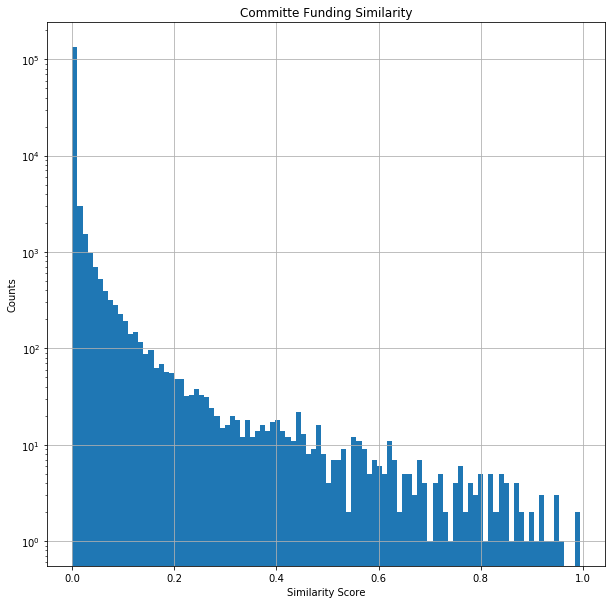

In [7]:
# Show histogram of funding similarity
fig = plt.figure(figsize=(10,10))
_ = plt.hist(list(zip(*projections.values()))[0], 100)
plt.grid(True)
plt.yscale('log')
plt.title('Committe Funding Similarity')
plt.xlabel('Similarity Score')
plt.ylabel('Counts')
plt.show()



In [8]:
similarities = pd.DataFrame(data=sorted(((key[0], key[1], val[0], val[1]) for key, val in projections.items()), key=lambda x: x[2], reverse=True), 
                          columns=['Committe1', 'Committe2', 'Similarity', 'Donor Overlap'])
display(similarities)

,Committe1,Committe2,Similarity,Donor Overlap
0,Nurses United Political Action Committee,Yes for Beaverton Schools,0.994240,1
1,Friends of Jesse,Friends of Jonathan Baker,0.993489,3
2,Nick Fish for City Council,Novick for Portland,0.961234,3
3,Portland Metropolitan Association of Realtors PAC,Rogue Valley Association of Realtors Political...,0.950375,1
4,Novick for Portland,Yes for Clean Water and Healthy Soil,0.948923,2
5,Nick Fish for City Council,Yes for Clean Water and Healthy Soil,0.945130,2
6,Anthony D Medina Oregon,Friends of Levi Herrera-Lopez,0.939743,3
7,Friends of Jeff Gudman,Oregon Association of Health Underwriters PAC,0.925499,1
8,Beaverton Area Chamber of Commerce Political A...,Hillsboro Chamber of Commerce PAC,0.921736,1
9,Friends of Michael Dembrow,"Future PAC, House Builders",0.919909,15


In [9]:
# Create Graph
SIM_CUTOFF = 0.5
edges = {(cnames[0], cnames[1]): sim[0] for cnames, sim in projections.items() if sim[0] >= SIM_CUTOFF}

graph = Graph(edges)
display(graph.calc_stats())

Number of nodes: 139
Number of edges: 204
Number of connected components: 40


,Degree,Connected Component Size
25.00%,1.00,2.00
50.00%,1.36,2.00
75.00%,3.30,3.00
90.00%,7.23,6.00
99.00%,9.90,16.20
100.00%,11.00,21.00


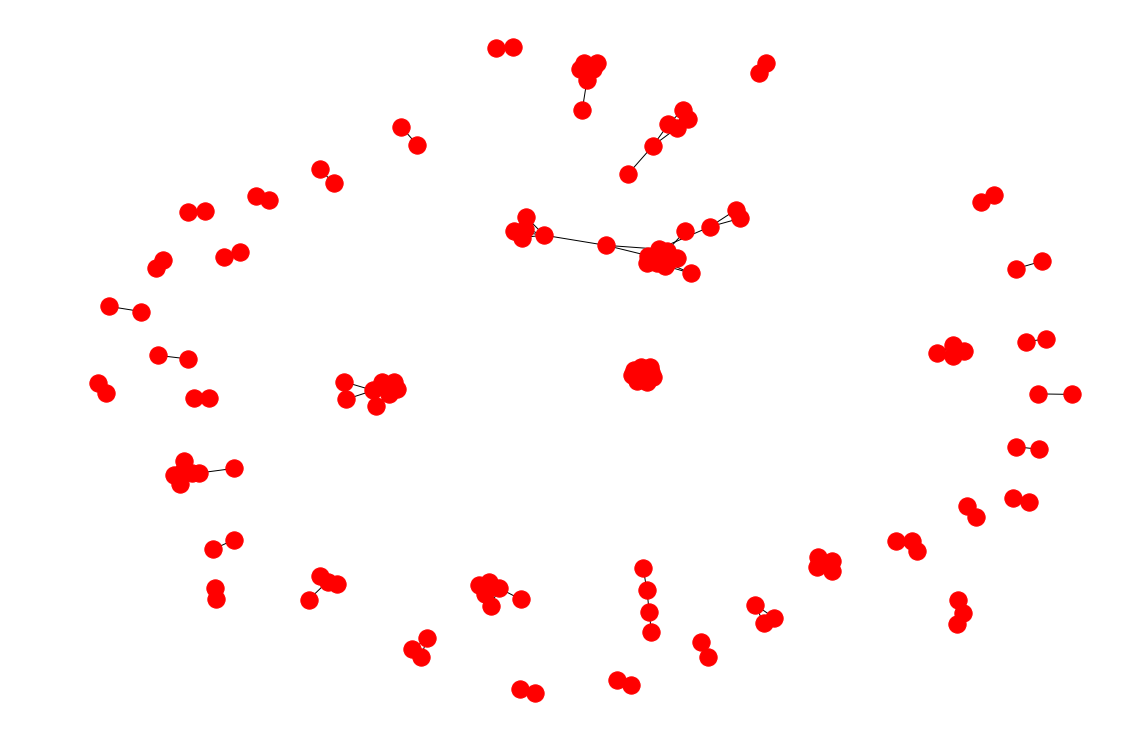

In [10]:
# Plot Graph
plt.figure(figsize=(15, 10))
nx.draw(graph.graph, font_weight='bold')

Caddy McKeown for Representative
Friends of Dan Rayfield
Friends of Margaret Doherty
Friends of Sheri Malstrom
Gomberg for State Rep
Mitch Greenlick for State Legislature
Reardon for Oregon
Friends of Arnie Roblan
Friends of Michael Dembrow
Friends of Alissa Keny-Guyer
Friends of Chris Gorsek
Friends of Diego Hernandez
Ken Helm for House District 34
Friends of Tobias Read
Friends of Jennifer Williamson
Friends of Rob Nosse
Friends of Tina Kotek
Friends of Elizabeth Steiner Hayward
Kate Brown Committee
Future PAC, House Builders
Friends of Nancy Nathanson

Donor Profile
Future PAC, House Builders (1524) (prct/overlap): 42.1% / 71.4%
ADP EasyPay (prct/overlap): 18.9% / 28.6%
Oregon Health Care Association PAC (275) (prct/overlap): 10.7% / 76.2%
C&E Systems (prct/overlap): 10.5% / 81.0%
Advanced Data Processing (ADP) (prct/overlap): 8.3% / 14.3%
Oregon Nurses Political Action Committee (12986) (prct/overlap): 4.9% / 38.1%
Oregon Soft Drink PAC (197) (prct/overlap): 4.7% / 52.4%


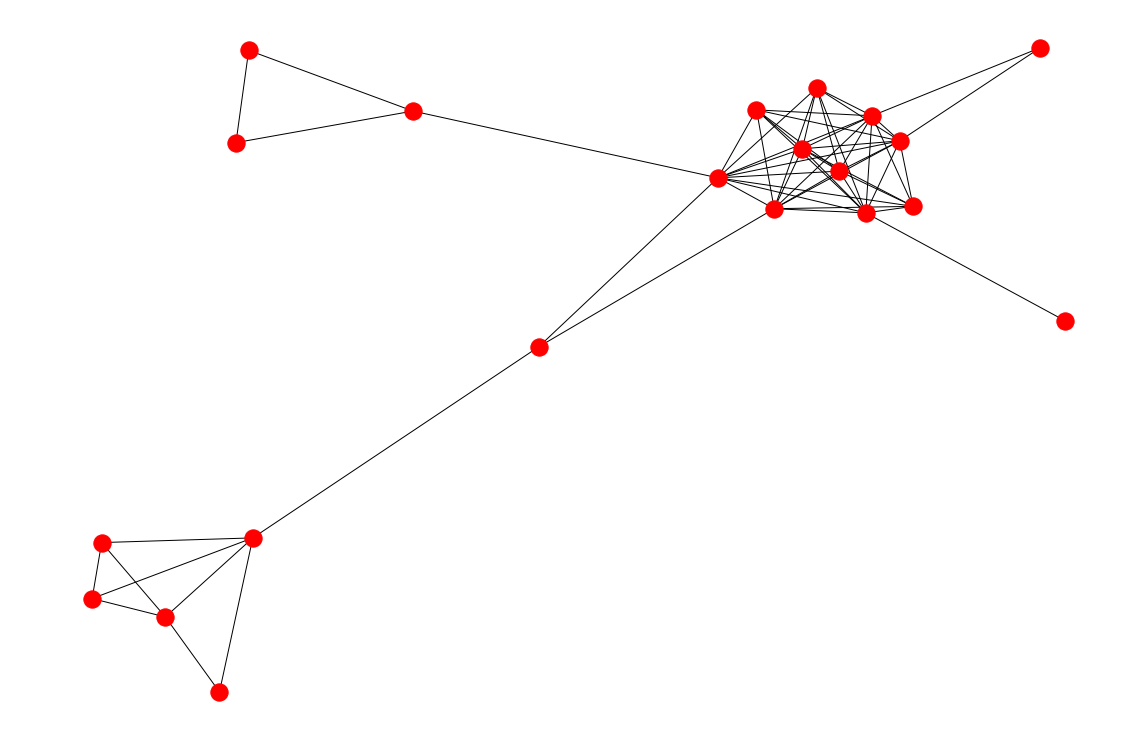

In [11]:
# Plot Largest Cluster
plt.figure(figsize=(15, 10))
nx.draw(graph.conn_comp[0], font_weight='bold')

neighborhood_names = set((graph.get_node_name(gid) for gid in graph.conn_comp[0]))
for cname in neighborhood_names:
    print(cname)

print('\nDonor Profile')
for donor, data in group_summary(agg_contributions, neighborhood_names, mode='union').items():
    print('{0:s} (prct/overlap): {1[0]:0,.1%} / {1[1]:0,.1%}'.format(donor, data))

Neighborhood Size: 9


,Committe1,Committe2,Similarity,Donor Overlap
53,Friends of Andy Olson,Joe Potwora for District 11,0.764992,1
58,Friends of Andy Olson,Friends of Sherrie Sprenger,0.755895,5
70,Friends of Andy Olson,Friends of David Brock Smith,0.717467,3
84,Barreto for HD 58,Friends of Andy Olson,0.681608,6
123,16538,Friends of Andy Olson,0.610278,5
133,Committee to Elect Mike McLane,Friends of Andy Olson,0.595772,2
143,Citizens to Elect Carl Wilson,Friends of Andy Olson,0.576479,4
163,Friends of Andy Olson,Friends of Vic Gilliam,0.556663,1



Donor Profile
Promote Oregon Leadership PAC (682) (prct/overlap): 52.5% / 100.0%
ADP, LLP (prct/overlap): 7.3% / 33.3%
ADP, LLC (prct/overlap): 5.0% / 22.2%
Mike McLane (prct/overlap): 3.8% / 11.1%
C & A Consulting (prct/overlap): 3.8% / 55.6%
Rebecca Gilliam (prct/overlap): 3.7% / 11.1%
Altria Client Services LLC ** (prct/overlap): 3.4% / 44.4%
Premier RV Resorts (prct/overlap): 3.1% / 11.1%
Koch Industries, Inc. ** (prct/overlap): 3.0% / 33.3%
Andy Olson (prct/overlap): 2.6% / 11.1%
Anheuser Busch Companies ** (prct/overlap): 2.6% / 22.2%
Grants Pass Broadcasting Corp. (prct/overlap): 2.5% / 11.1%
Oregon Realtors Political Action Committee (191) (prct/overlap): 2.4% / 33.3%
Anheuser - Busch Companies ** (prct/overlap): 2.3% / 11.1%
Verizon Wireless (prct/overlap): 2.0% / 22.2%


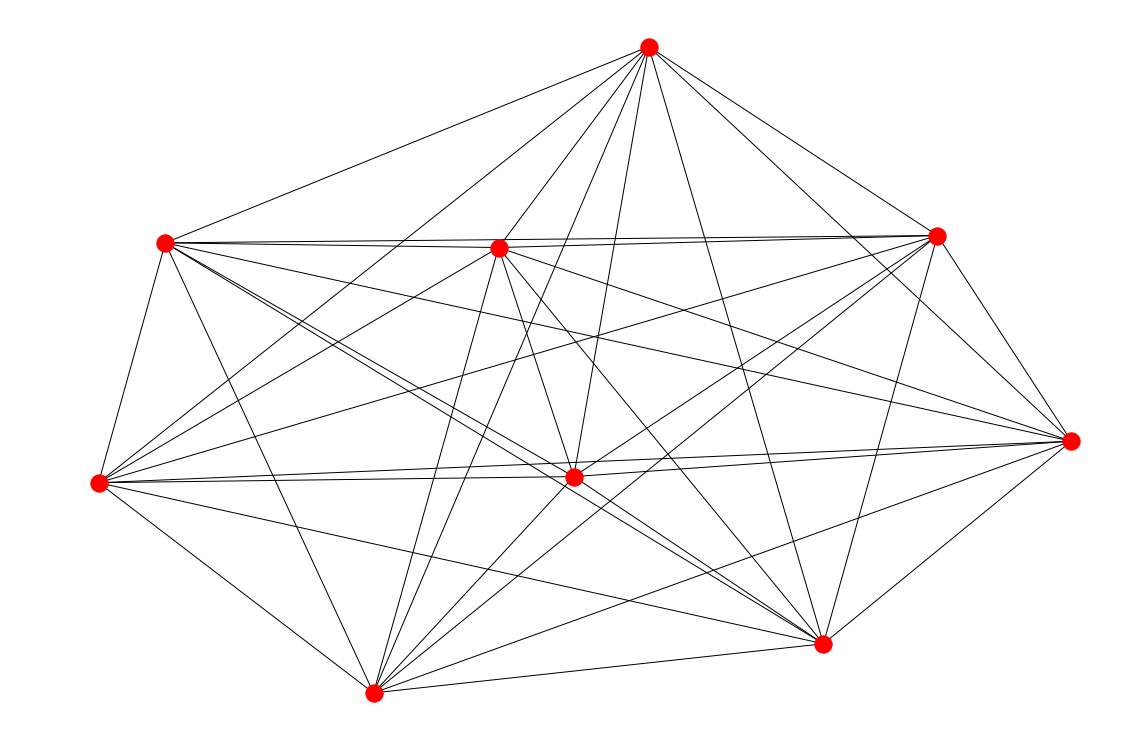

In [12]:
# Plot neighborhood
node_name = 'Friends of Andy Olson'
neighborhood = graph.get_neighborhood(node_name=node_name, distance=None)
plt.figure(figsize=(15, 10))
nx.draw(neighborhood, font_weight='bold')

neighborhood_names = set((graph.get_node_name(gid) for gid in neighborhood.nodes()))
print('Neighborhood Size: {:,.0f}'.format(len(neighborhood_names)))
display(similarities[(similarities['Similarity'] >= SIM_CUTOFF) & ((similarities['Committe1'] == node_name) | (similarities['Committe2'] == node_name))])


print('\nDonor Profile')
for donor, data in group_summary(agg_contributions, neighborhood_names, mode='union').items():
    print('{0:s} (prct/overlap): {1[0]:0,.1%} / {1[1]:0,.1%}'.format(donor, data))

In [13]:
display(similarities[similarities['Similarity'] >= SIM_CUTOFF][similarities['Committe1'].apply(lambda x: x in neighborhood_names)])


/Users/ggemelos/anaconda3/envs/elections2018/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Committe1,Committe2,Similarity,Donor Overlap
27,Barreto for HD 58,Joe Potwora for District 11,0.842446,1
34,Friends of Sherrie Sprenger,Joe Potwora for District 11,0.819549,1
39,16538,Barreto for HD 58,0.798838,20
45,Friends of David Brock Smith,Friends of Sherrie Sprenger,0.791447,5
52,Friends of David Brock Smith,Joe Potwora for District 11,0.766620,1
53,Friends of Andy Olson,Joe Potwora for District 11,0.764992,1
58,Friends of Andy Olson,Friends of Sherrie Sprenger,0.755895,5
59,16538,Joe Potwora for District 11,0.755290,1
60,Committee to Elect Mike McLane,Joe Potwora for District 11,0.754326,1
65,Barreto for HD 58,Friends of Sherrie Sprenger,0.728304,6


In [14]:
# Visualize in D3
node_name = 'Friends of Andy Olson'
neighborhood = graph.get_neighborhood(node_name=node_name, distance=None)
# neighborhood = graph.conn_comp[2]

graph.show_in_d3_force_directed(file_path='/Users/ggemelos/Dropbox/documents/hackoregon/data/d3graph',
                                nodes=set(neighborhood.nodes),
                                groups={'target': [graph.get_node_id(node_name)]})